# Candy bar product design

**Author**: Chinh X. Mai, **Date**: September 9, 2022

## Table of contents <a class=anchor id=0></a>

* [1 Case description](#1)
* [2 Data description](#2)
* [3 Requirements](#3)
* [4 Important packages and analytical pipeline](#4)
* [5 Initial investigation](#5)
* [6 Regression analysis](#6)
    * [6.1 Simple OLS regression](#6.1)
    * [6.2 Stepwise selection](#6.2)
* [7 Executive summary and Conclusion](#7)

## [1 Case description](#0)  <a class=anchor id=1></a>

The purchasing department of your firm would like to expand the confectionery assortment (private label). A new candy is to be created for this purpose. However, there is still disagreement within the relevant project team about the characteristics of the new candy.

For example, while some prefer a cookie-based candy, others favor a fruit gum variation. The divisional board therefore decided to commission a market research company to determine the popularity of the sweets available on the market.

The results of the market research are now available and you have been commissioned to carry out an analysis of the data. The aim is to analyze the impact of the characteristics of confectionery on their popularity and, based on this analysis, to make a recommendation for the new confectionery.

# [2 Data description](#0)   <a class=anchor id=3></a>

The data is taken from the following case: 

[The Ultimate Halloween Candy Power Ranking](https://fivethirtyeight.com/videos/the-ultimate-halloween-candy-power-ranking/)

`candy-data.csv` includes attributes for each candy along with its ranking. For binary variables, 1 means yes, 0 means no.

The data contains the following fields:

* **chocolate**: Does it contain chocolate?
* **fruity**: Is it fruit flavored?
* **caramel**: Is there caramel in the candy?
* **peanutalmondy**: Does it contain peanuts, peanut butter or almonds?
* **nougat**: Does it contain nougat?
* **crispedricewafer**: Does it contain crisped rice, wafers, or a cookie component?
* **hard**: Is it a hard candy?
* **bar**: Is it a candy bar?
* **pluribus**: Is it one of many candies in a bag or box?
* **sugarpercent**: The percentile of sugar it falls under within the data set.
* **pricepercent**: The unit price percentile compared to the rest of the set.
* **winpercent**: The overall win percentage according to 269,000 matchups.

The `winpercent` is the probability of winning when being matched with another brand as shown in the [Figure](#f1) below

**Figure 1**: example matchup (source: [walthickey](http://walthickey.com/2017/10/18/whats-the-best-halloween-candy/)) <a class=anchor id=f1></a>

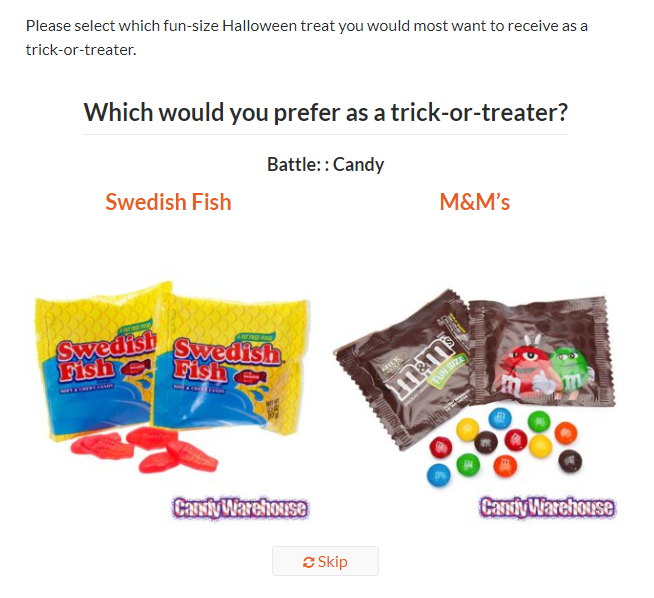

# [3 Requirements](#0)   <a class=anchor id=3></a>

The project will be delivered in terms of a board presentation to the firm managerment. The presentation will last at most 15 minutes and should not focus too much on the technical details. Since the presentation is for the management, it should be short and go directly to the point by first providing an executive summary and some technical details later. Moreover, as the project will be presented in a online meeting, the participants will be close enough to the screen to read the details, but visualizations will be utilized to tell the story as they would be more intuitive and attract more attention.

# [4 Important packages and analytical pipeline](#0) <a class=anchor id=4></a>

Since the data is quite simple to analyze, the pipeline will be quite intuitive, a simple diagram of the pipeline is given in the [Figure](#f2) below

**Figure 2**: Analytical pipeline (source: self generated) <a class=anchor id=f2></a>

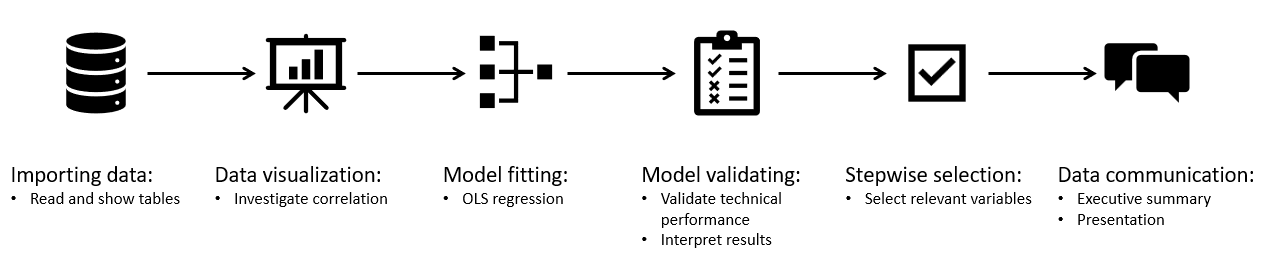

To implement this process, it is necessary to import essential packages first.

In [1]:
# Data and array manipulation
import pandas as pd
import numpy as np
import datetime as dt

# Regression analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Plotting and Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import cufflinks as cf

# Interactive charts
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Options
init_notebook_mode(connected = True)
cf.go_offline()
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)

# [5 Initial investigation](#0)   <a class=anchor id=5></a>

Firstly, let's load the data and investigate it briefly

In [2]:
# Load the data
df = pd.read_csv('candy-data.csv')

# Assign dummy and numerical columns
dummies = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']
numerical = ['sugarpercent', 'pricepercent', 'winpercent']

# Show the data
df\
    .sort_values(dummies, ascending = False)\
    .set_index('competitorname')\
    .style\
    .format({'sugarpercent': '{:.2%}', 'pricepercent': '{:.2%}', 'winpercent': '{:,.2f}'})\
    .highlight_max(dummies, color = 'lightgreen')\
    .highlight_min(dummies, color = 'white')\
    .bar(color = '#ff8b59', subset = numerical, align = 'zero', height = 80)

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
competitorname,,,,,,,,,,,,
Tootsie Pop,1,1,0,0,0,0,1,0,0,60.40%,32.50%,48.98
Baby Ruth,1,0,1,1,1,0,0,1,0,60.40%,76.70%,56.91
Snickers,1,0,1,1,1,0,0,1,0,54.60%,65.10%,76.67
Snickers Crisper,1,0,1,1,0,1,0,1,0,60.40%,65.10%,59.53
Milky Way,1,0,1,0,1,0,0,1,0,60.40%,65.10%,73.10
Milky Way Midnight,1,0,1,0,1,0,0,1,0,73.20%,44.10%,60.80
100 Grand,1,0,1,0,0,1,0,1,0,73.20%,86.00%,66.97
Twix,1,0,1,0,0,1,0,1,0,54.60%,90.60%,81.64
Milky Way Simply Caramel,1,0,1,0,0,0,0,1,0,96.50%,86.00%,64.35


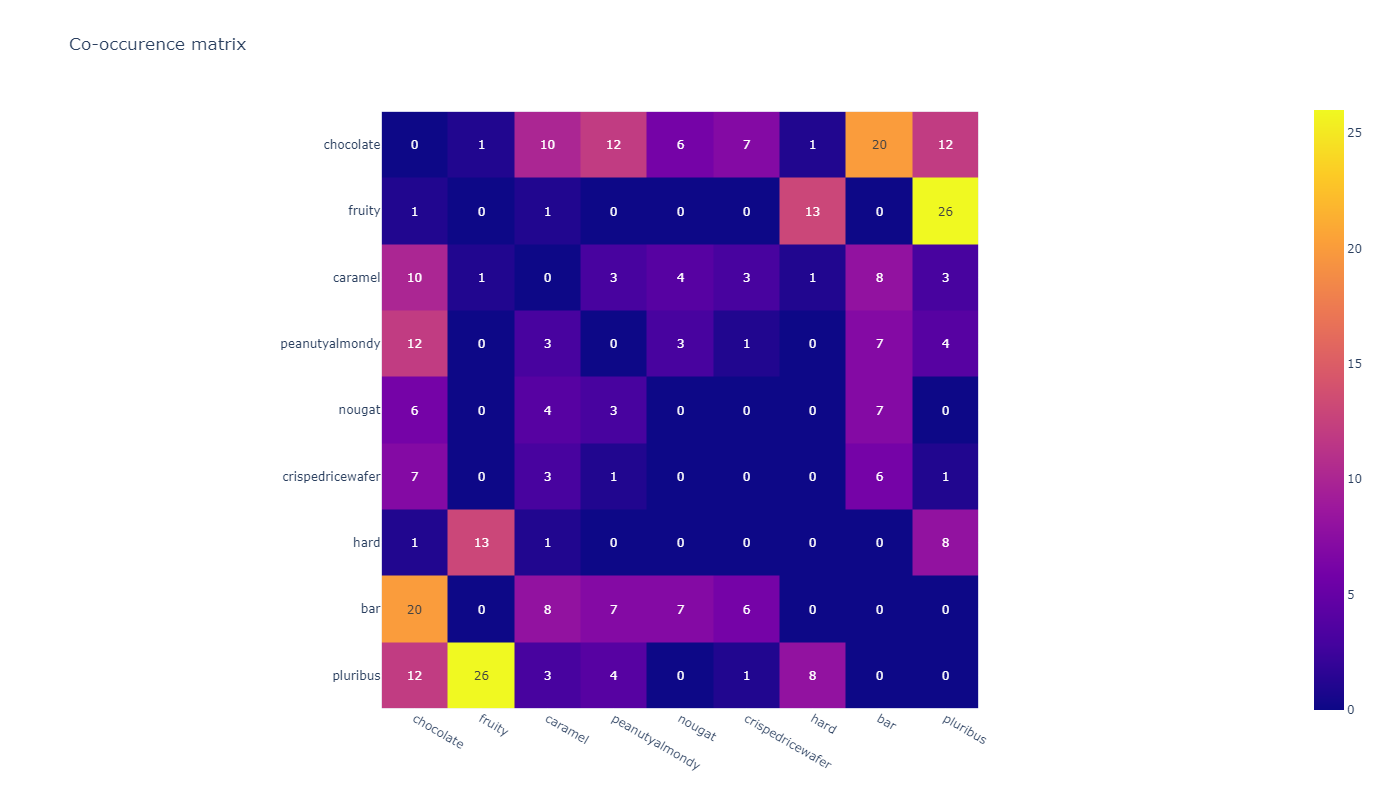

In [3]:
# Generate empty count table
feature = df[dummies].columns
count = np.repeat(0, 9)
tab_co = pd.DataFrame([count, count, count,
                       count, count, count,
                       count, count, count], 
                       index = feature, 
                       columns = feature)

# count co-occurences
df_dummies = df[dummies]
for i in range(9):
    for j in range(i + 1, 9, 1):
        for x in df_dummies.index:
            if (df_dummies.iloc[x, i] == 1) and (df_dummies.iloc[x, j] == 1):
                tab_co.iloc[i, j] += 1
                tab_co.iloc[j, i] += 1

# print the table
fig = px.imshow(tab_co, text_auto = '.0f', width = 800, height = 800, title = 'Co-occurence matrix')
fig.show()

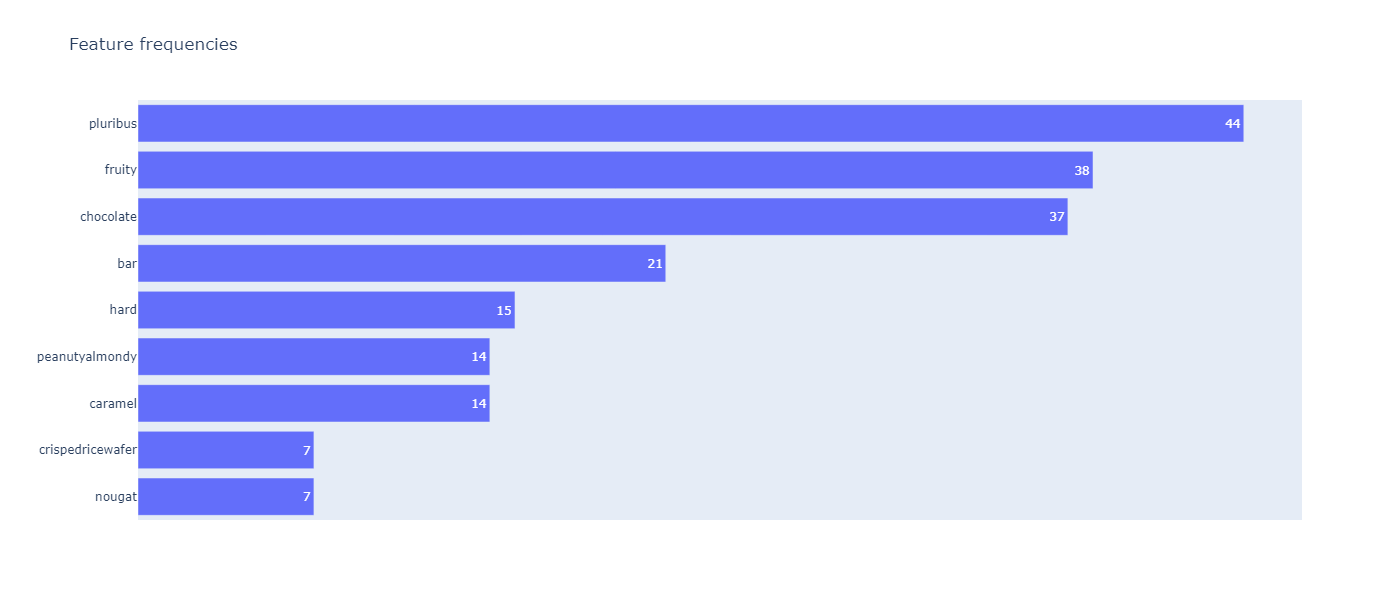

In [4]:
# Feature frequencies 
fig = px.bar(x = df[dummies].sum(axis = 0).sort_values(), 
             y = df[dummies].sum(axis = 0).sort_values().index,
             labels = {'x': '', 'y': ''},
             title = 'Feature frequencies',
             text_auto = True,
             width = 800,
             height = 600)
fig.update_layout(yaxis_visible = True, xaxis_visible = False, xaxis_showticklabels = False)
fig.show()

The dataset contains information about product characteristics of different candy bars. The main purpose of the data is to use these characteristics to explain the popularity of the product. Generally speaking, the data is quite clean and doesn’t need any further transformation. It has 13 features and 85 observations.

As can be seen from the table, some of the features tend to appear together in a product, so they might be highly correlated. Moreover, the numerical factors seem to be not correlated to each other. This can be observed more clearly in the Scatter matrix below

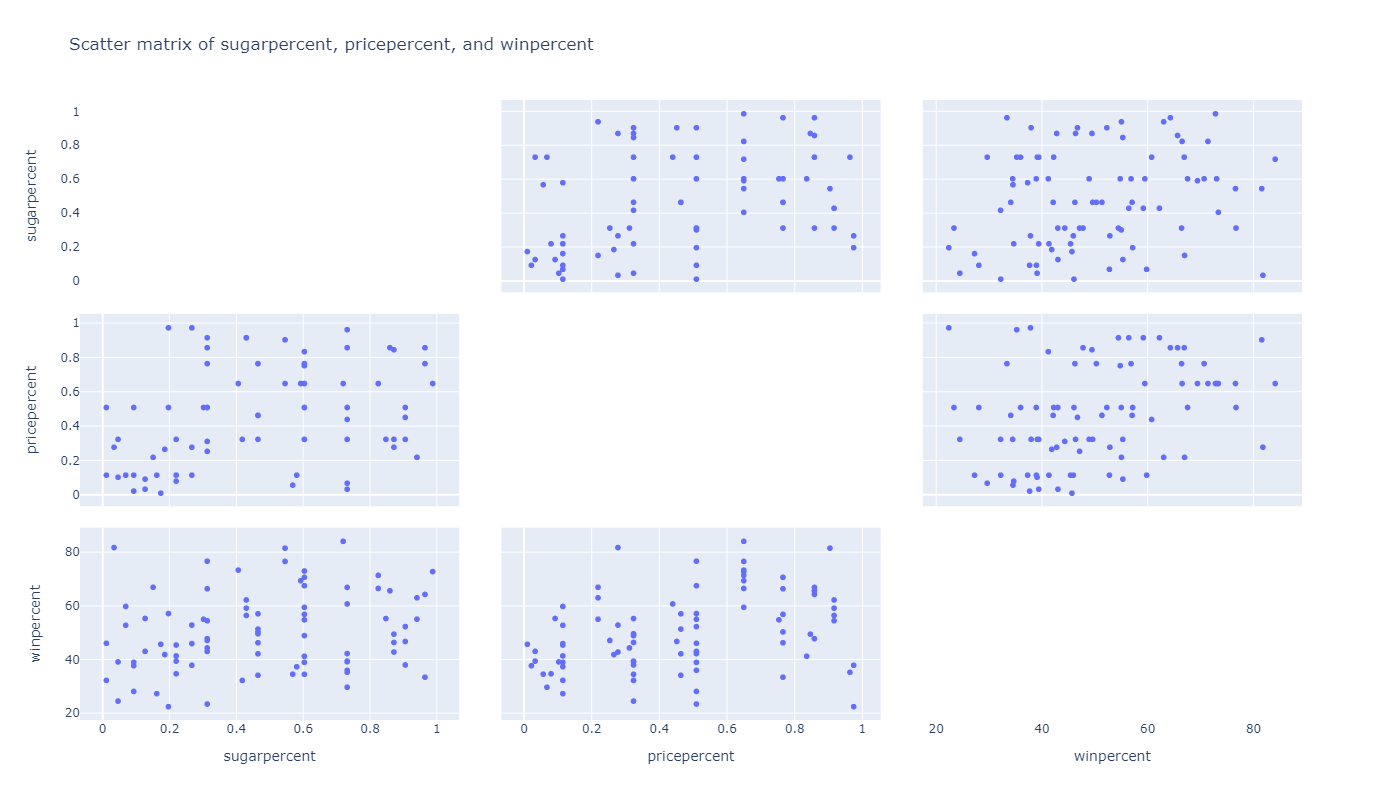

In [5]:
# Scatter plot matrix
fig = px.scatter_matrix(df[numerical],
                        height = 800,
                        width = 800,
                        title = 'Scatter matrix of sugarpercent, pricepercent, and winpercent')

# Update layout to reduce clutter
fig.update_traces(diagonal_visible = False)

# Show figure
fig.show()

The actual correlations are shown in the correlation matrix below

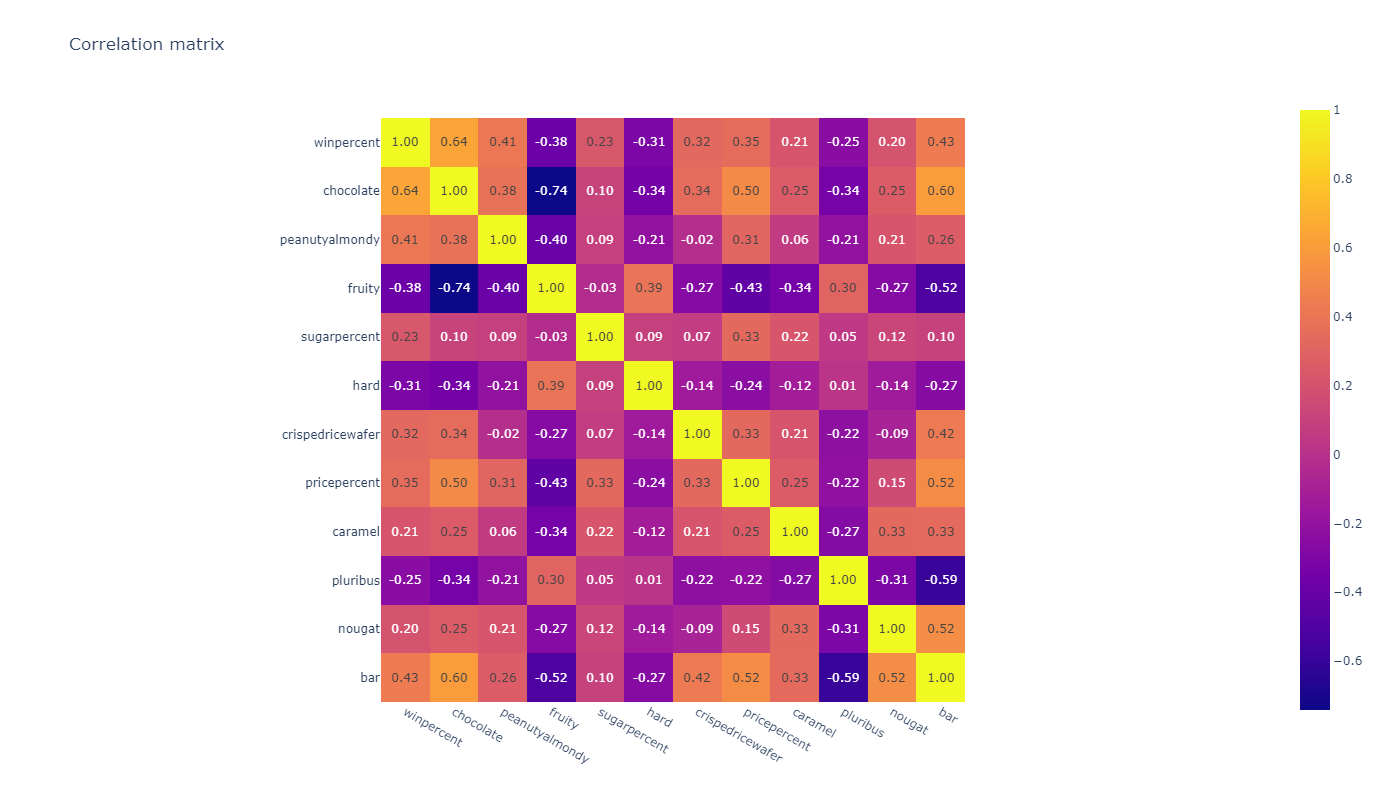

In [17]:
# ordering variables for later use
order_column = ['winpercent', 'chocolate', 'peanutyalmondy', 
                'fruity', 'sugarpercent', 'hard', 
                'crispedricewafer', 'pricepercent', 'caramel', 
                'pluribus', 'nougat', 'bar']

# Correlation matrix
fig = px.imshow(df[order_column].corr(), text_auto = '.2f', width = 800, height = 800, 
                title = 'Correlation matrix')
fig.show()

Overall, it can be seen from the matrix that `sugarpercent` correlates weakly with other factors, compared to the rest. Furthermore, most factors are correlated from moderately to strongly to others. This might cause problems when running regression analyses as the standard deviations will inflate when explanatory factors are correlated.

# [6 Regression analysis](#0) <a class=anchor id=6></a>

## [6.1 Simple OLS regression](#0) <a class=anchor id = 6.1></a>

Let's confirm our concerns about the issues caused by the multicollinearity by fitting a multiple linear model containing all the available explanatory variables first:

In [7]:
# Prepare variables for modelling
df_y = df['winpercent']
df_x = sm.add_constant(df.drop(['competitorname', 'winpercent'], axis = 1))

# Fit the model
model_full = sm.OLS(df_y, df_x)
result_full = model_full.fit()

Firstly, let's look at the technical performance of the model

In [8]:
# performance diagnostic
result_full.summary().tables[0]

Dep. Variable:,winpercent,R-squared:,0.540
Model:,OLS,Adj. R-squared:,0.471
Method:,Least Squares,F-statistic:,7.797
Date:,"Sun, 11 Sep 2022",Prob (F-statistic):,9.50e-09
Time:,18:22:17,Log-Likelihood:,-315.64
No. Observations:,85,AIC:,655.3
Df Residuals:,73,BIC:,684.6
Df Model:,11,,
Covariance Type:,nonrobust,,


In [9]:
# residuals diagnostic
result_full.summary().tables[2]

Omnibus:,1.025,Durbin-Watson:,1.728
Prob(Omnibus):,0.599,Jarque-Bera (JB):,1.000
Skew:,-0.104,Prob(JB):,0.606
Kurtosis:,2.511,Cond. No.,10.0


The first table shows statistics for diagnosing how well the model performs technically:

* The **adjusted R-squared** statistic shows that the model explain approximately 47 percent of the variations in the `winpercent`, which is quite high for such a simple model. 
* The **F-statistic** being 7.797 with a very low **Prob(F-statistic)** indicates that at least one of the chosen explanatory variables significantly contributes to the changes in `winpercent`. 
* **Log-Likelihood** is the statistics used to compare models so we will use it in the later section. Overall, these diagnostic statistics indiate that the employed model is doing a good job in explaining the dependent variable.

The second table shows statistics for diagnosing the normality of the residuals. Due to the OLS assumption of normality in the residuals, statistics in this table are important to evaluate whether the model is valid. 

* **Omnibus** and **Prob(Omnibus)** are two statistics used to check the normality in the residuals. We should expect an **Omnibus** close to zero and a **Prob(Omnibus)** close to one, which signifies that the probability for the residual to be normally distributed is 100 percents. 
* **Skew** and **Kurtosis** are the statistics used to present skewness and flatness of the model, we should expect a Skew close to zero and a Kurtosis close to 3 to prove normalcy. In this case, it seems that the residuals are normally distributed
* **Durbin-Watson** statistic provides a measure of autocorrelation in the residual. If the residual values are autocorrelated, the model becomes biased and it is not expected. This simply means that one value should not be depending on any of the previous values. An ideal value for this test ranges from 0 to 4.
* **Jarque-Bera (JB)** and **Prob(JB)** is similar to Omni test measuring the normalcy of the residuals.
* High **Cond. No.** indicates that there are possible multicollinearity present in the dataset. If only one variable is used as predictor, this value is low and can be ignored. We can proceed like stepwise regression and see if there is any multicollinearity added when additional variables are included.

Next, let's have a look at the effects

In [10]:
# formatting functions for highlighting 
def add_color_p(x):
    if x < 0.05:
        color = '#03fca9'
    elif x < 0.1:
        color = '#f0d88b'
    else:
        color = '#e83c5c'
    return f'background: {color}'

def add_color_t(x):
    if np.abs(x) > 1.96:
        color = '#03fca9'
    elif np.abs(x) > 1.645:
        color = '#f0d88b'
    else:
        color = '#e83c5c'
    return f'background: {color}'

# effects diagnostic
eff_full = result_full.summary().tables[1]
eff_full = pd.read_html(eff_full.as_html(), header = 0, index_col = 0)[0]
eff_full.sort_values('P>|t|')\
    .style\
    .format({'P>|t|': '{:.2%}', 'coef': '{:.2f}', 'std err': '{:.2f}', 't': '{:.2f}', '[0.025': '{:.2f}', '0.975]': '{:.2f}'})\
    .bar(color = ['#e83c5c', '#03fca9'], subset = ['coef', 'std err'], align = 'zero', height = 80)\
    .applymap(add_color_t, subset = ['t'])\
    .applymap(add_color_p, subset = ['P>|t|'])

,coef,std err,t,P>|t|,[0.025,0.975]
const,34.53,4.32,7.99,0.00%,25.92,43.14
chocolate,19.75,3.90,5.07,0.00%,11.98,27.52
peanutyalmondy,10.07,3.62,2.79,0.70%,2.86,17.28
fruity,9.42,3.76,2.50,1.50%,1.92,16.92
sugarpercent,9.09,4.66,1.95,5.50%,-0.20,18.37
hard,-6.17,3.46,-1.78,7.90%,-13.05,0.72
crispedricewafer,8.92,5.27,1.69,9.50%,-1.58,19.42
pricepercent,-5.93,5.51,-1.07,28.60%,-16.92,5.06
caramel,2.22,3.66,0.61,54.50%,-5.07,9.51
pluribus,-0.85,3.04,-0.28,77.90%,-6.91,5.20


The column **coef** shows the size of the estimated effect of the explanatory variables on the dependent variable `winpercent`. **std err** is the standard error of the estimate. **t** and **P>|t|** values are diagnostic statistics used to evaludate whether the effects are statistically significant.

As can be seen from the table, light green cells signify that the estimated coefficient is significant at 5 percent, the light yellow is for being significant at 10 percent, and the red is for statistically insignificant. From this information, we can see `pricepercent`, `caramel`, `pluribus`, `nougat` and `bar` do not have significant effect on winning percentage in matchups.

Considering the fact that the model is technically valid, this result suggests that:

* A candy does not contain any of the ingredients being considered has an average win rate of 34.53 percent, this is presented by the constant (34.53)
* Containing `chocolate` increases the winning chance by 19.75 percent, this is presented by the coefficient of `chocolate` (19.75). This logic applies similarly and respectively to `peanutyalmondy`, `fruity`, and `crispedricewafer`
* A hard candy bar reduces the winning rate by 6.17 percent, this is presented by the coefficient of `hard` (6.17)
* As the sugar percentile increases by 100 percent, the winning rate increases by 9.09 percent, this is presented by the coefficient of `sugarpercent` (9.09)

This conclusion is already good enough for constructing a product with high winning rate, but we can still do better with a stepwise selection to choose the relevant variables for our model.

## [6.2 Stepwise selection](#0) <a class=anchor id = 6.2></a>

**Stepwise selection** is the step-by-step iterative construction of a regression model that involves the selection of independent variables to be used in a tuned model. It involves adding or removing potential explanatory variables in succession and testing for statistical significance after each iteration. The pitfall of this technique is that it might ignore potentially insignificant explanatory variables while these variables really have causal connections with the dependent variable. In this case, all explanatory factors are causally equivalent to explain the dependent variable. This section employs the forward stepwise selection approach to select significant explanatory variables for our model.

This approach is executed by the following helper function:

In [11]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    
    return model

This helper function will start with a model with only the constant, then add one more variable to the model, refit it, and evaluate impact of the added variable using adjusted R-squared. This process is repeated until the adjusted R-square decreases as more variables are added. The output is a model with all selected variables that have positive impacts on the adjusted R-squared.

In [12]:
model = forward_selected(df.drop('competitorname', axis = 1), 'winpercent')
model.model.formula

'winpercent ~ chocolate + peanutyalmondy + fruity + crispedricewafer + sugarpercent + hard + pricepercent + 1'

The stepwise selection suggests a model that only contains explanatory factors having statistically significant impacts on `winpercent`, except for `pricepercent`. As the helper function will stop at the factor that reduces the adjusted R-squared, we have to exclude the last variable, here is `pricepercent`, because the factor does not add any value to the model. The final model is then

In [13]:
model_selected = smf.ols('winpercent ~ chocolate + peanutyalmondy + fruity + crispedricewafer + sugarpercent + hard + 1', data = df)
result_selected = model_selected.fit()

In [14]:
result_selected.summary().tables[0]

Dep. Variable:,winpercent,R-squared:,0.528
Model:,OLS,Adj. R-squared:,0.492
Method:,Least Squares,F-statistic:,14.54
Date:,"Sun, 11 Sep 2022",Prob (F-statistic):,4.62e-11
Time:,18:22:18,Log-Likelihood:,-316.76
No. Observations:,85,AIC:,647.5
Df Residuals:,78,BIC:,664.6
Df Model:,6,,
Covariance Type:,nonrobust,,


In [15]:
result_selected.summary().tables[2]

Omnibus:,0.545,Durbin-Watson:,1.735
Prob(Omnibus):,0.761,Jarque-Bera (JB):,0.682
Skew:,-0.093,Prob(JB):,0.711
Kurtosis:,2.602,Cond. No.,6.32


In [16]:
# effects diagnostic
eff_selected = result_selected.summary().tables[1]
eff_selected = pd.read_html(eff_selected.as_html(), header = 0, index_col = 0)[0]
eff_selected\
    .sort_values('P>|t|')\
    .style\
    .format({'P>|t|': '{:.2%}', 'coef': '{:.2f}', 'std err': '{:.2f}', 't': '{:.2f}', '[0.025': '{:.2f}', '0.975]': '{:.2f}'})\
    .bar(color = ['#e83c5c', '#03fca9'], subset = ['coef', 'std err'], align = 'zero', height = 80)\
    .applymap(add_color_t, subset = ['t'])\
    .applymap(add_color_p, subset = ['P>|t|'])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.94,3.52,9.37,0.00%,25.94,39.94
chocolate,19.15,3.59,5.34,0.00%,12.01,26.29
peanutyalmondy,9.48,3.45,2.75,0.70%,2.62,16.34
fruity,8.88,3.56,2.49,1.50%,1.79,15.97
sugarpercent,7.98,4.13,1.93,5.70%,-0.24,16.20
crispedricewafer,8.39,4.48,1.87,6.50%,-0.54,17.31
hard,-5.67,3.29,-1.72,8.90%,-12.22,0.88


The model suggested by stepwise selection is better in terms of both technical performance and statistical significance. All the factors are statistically significant at 10 percent and the model explains 52.8 percent of the variations in the dependent variable `winpercent`.

# [7 Executive summary and Conclusion](#0) <a class=anchor id = 7></a>

This project aims to find the characteristics of a candy bar that has the highest winning probability when matched with another. Employing `pandas`, `numpy`, `plotly`, and `statsmodel`, the analysis involves basic steps such as data import and visualization, the main workhorse is an OLS regression supported by a stepwise selection. Data includes 13 features and 85 observations, of which nine features are binary and others are numerical. The analysis shows that:

* A generic brand without any of ingredients has an estimated average winning rate of approximately 33 percent
* Among other factors, only `chocolate`, `peanutyalmondy`, `fruity`, `crispedricewafer`, `sugarpercent`, and `hard` have statistically significant impacts on `winpercent`
* In the significant factors, `hard` has a negative impact while others have positive impacts

The analysis concludes that a candy having highest winning rate is the candy including chocolate, peanutyalmondy, fruity, crispedricewafer and a high amount of sugar.